In [31]:
import scipy.io as scio
import pandas as pd
import numpy as np
import os
from pandas import Series,DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score  
from sklearn.decomposition import PCA

import time
import cProfile

sns.set()

In [32]:
random.seed(3345)

In [33]:
def distance_feature(x): # calcuate distance between points, choose uprigt triangle
    #sqrt(dx^2+dy^2)
    a = (x[None, :, :] - x[:, None, :])
    b = np.linalg.norm(a, axis=2)
    return b[np.triu_indices(78, 1)] # feature size (78-1)(78-2) /2 

In [34]:
def euc_distance_feature(x): # instead of distance, keep two dimensional distance vector
    #(dx,dy)
    a = (x[None, :, :] - x[:, None, :])
    index = np.triu_indices(78, 1)
    b = a[index]
    return b.reshape((-1,)) # feature size (78-1)(78-2) /2 * 2

In [35]:
df = pd.read_csv("../../data/train_set/label.csv")
labels = df["emotion_idx"].tolist()

In [36]:
data = list()
for i in range(1, 2501):
    name = "../../data/train_set/points/%04d.mat" % i
    dic = scio.loadmat(name)
    if "faceCoordinatesUnwarped" in dic:
        data.append(dic["faceCoordinatesUnwarped"])
    else:
        data.append(dic["faceCoordinates2"])

In [37]:
# shuffle data
data, labels = shuffle(data, labels, random_state=0)

In [38]:
x_train, x_test, train_y, test_y = train_test_split(data, labels, test_size=0.2)

### First we try the distance as features 

In [47]:
train_x = [distance_feature(d) for d in x_train]
test_x = [distance_feature(d) for d in x_test]

GBM 

In [41]:
start = time.time()
gbm = GradientBoostingClassifier(learning_rate=0.01,n_estimators=30,random_state=10).fit(train_x, train_y)
end = time.time()
print("Training Time:","%s seconds"%(end - start))

Training Time: 315.51803493499756 seconds


In [48]:
print("Training dataset Accuracy")
train_accuracy = gbm.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = gbm.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.6715
Testing dataset Accuracy
0.352


Logistic Regression

In [49]:
start = time.time()
clf = LogisticRegression(max_iter=800, penalty = "l2", random_state=0, solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(train_x, train_y)
end = time.time()
print("Training Time:","%s seconds"%(end - start))

Training Time: 44.65966796875 seconds


In [50]:
print("Training dataset Accuracy")
train_accuracy = clf.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = clf.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.827
Testing dataset Accuracy
0.524


Random Forest

In [51]:
forest = RandomForestClassifier(n_estimators=500, oob_score = True, 
                                max_depth=12, max_leaf_nodes=15,
                                max_features="auto", n_jobs=-1)

In [52]:
start = time.time()
forest.fit(train_x, train_y)
end = time.time()
print("Training Time:","%s seconds"%(end - start))
print("Training dataset Accuracy")
train_accuracy = forest.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = forest.score(test_x, test_y) 
print(test_accuracy)

Training Time: 5.376339912414551 seconds
Training dataset Accuracy
0.4765
Testing dataset Accuracy
0.34


### Second we try euclidien distance as features 

In [53]:
train_x = [euc_distance_feature(d) for d in x_train]
test_x = [euc_distance_feature(d) for d in x_test]

In [54]:
start = time.time()
clf = LogisticRegression(max_iter=800, random_state=0,  penalty = "l2", solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(train_x, train_y)
end = time.time()
print("Training Time:","%s seconds"%(end - start))

Training Time: 86.79553818702698 seconds


In [55]:
print("Training dataset Accuracy")
train_accuracy = clf.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = clf.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.8695
Testing dataset Accuracy
0.508


xgboost

In [56]:
import xgboost as xgb

In [57]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)

In [58]:
param = {'booster':'gbtree',
'objective': 'multi:softmax', 
'num_class':23,
'gamma':0.05,  
'max_depth':5, 
'silent':1 ,
'subsample': 0.4,
'eta': 0.001}
num_round=2
start = time.time()
bst = xgb.train(param, dtrain, num_round)
end = time.time()
print("Training Time:","%s seconds"%(end - start))
train_preds = bst.predict(dtrain)
train_accuracy = accuracy_score(train_y, train_preds) #使用sklearn进行比较正确率
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))

Training Time: 41.68709707260132 seconds
Train Accuary: 54.20%


In [59]:
test_preds = bst.predict(dtest)
test_accuracy = accuracy_score(test_y, test_preds) #使用sklearn进行比较正确率
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 30.40%


### KNN

In [60]:
train_x = [euc_distance_feature(d) for d in x_train]
test_x = [euc_distance_feature(d) for d in x_test]

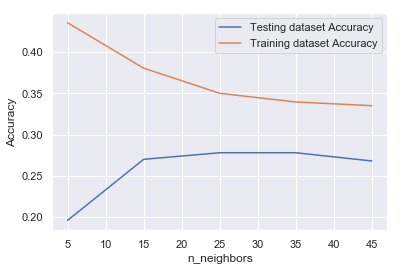

In [61]:
neighbors = np.arange(5, 50, 10) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(train_x, train_y) 
      
    # Compute traning and test data accuracy 
    train_accuracy[i] = knn.score(train_x, train_y) 
    test_accuracy[i] = knn.score(test_x, test_y) 
  
# Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

In [62]:
start = time.time()
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x, train_y) 
end = time.time()
print("Training Time:","%s seconds"%(end - start))

Training Time: 0.35967516899108887 seconds


In [63]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = knn.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.35
Testing dataset Accuracy
0.278


In [64]:
pca = PCA(n_components=48).fit(train_x)
train_x_reduce = pca.transform(train_x)

In [65]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x_reduce, train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

In [66]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x_reduce, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = knn.score(pca.transform(test_x), test_y) 
print(test_accuracy)

Training dataset Accuracy
0.3505
Testing dataset Accuracy
0.278
